# Problem 1

Check the activations and gradients of zero initialized networks. See what's happening?

## Create dataset

In [1]:
with open('../names.txt', "r") as file:
    names = file.read().splitlines()

len(names)

32033

In [2]:
chars = sorted(list(set("".join(name for name in names))))
chars

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [3]:
stoi, itos = {}, {}

stoi['.'] = 0
itos[0] = '.'

for i, char in enumerate(chars):
    stoi[char] = i + 1
    itos[i + 1] = char

len(stoi), len(itos)

(27, 27)

In [4]:
import random

def split_dataset(names, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    # Ensure the ratios sum to 1
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1"
    
    # Set the random seed for reproducibility
    random.seed(seed)
    
    # Shuffle the names
    random.shuffle(names)
    
    # Calculate the split indices
    total = len(names)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)
    
    # Split the dataset
    train_names = names[:train_end]
    val_names = names[train_end:val_end]
    test_names = names[val_end:]
    
    return train_names, val_names, test_names

# Split the dataset
train_names, val_names, test_names = split_dataset(names)

# Print the lengths of each split to verify
print(f"Train set size: {len(train_names)}")
print(f"Validation set size: {len(val_names)}")
print(f"Test set size: {len(test_names)}")

Train set size: 25626
Validation set size: 3203
Test set size: 3204


In [7]:
import torch

def create_dataset(names, window_size=3):
    X, y = [], []

    for name in names:
        name = ['.'] * window_size + list(name) + ['.']

        for i, ch in enumerate(name[window_size:]):
            input_context = name[i:i + window_size]
            X.append([stoi[c] for c in input_context])
            y.append(stoi[ch])

    X = torch.tensor(X).long()
    y = torch.tensor(y).long()

    return X, y

In [8]:
# Create training dataset
X_train, y_train = create_dataset(train_names)

# Create validation dataset
X_val, y_val = create_dataset(val_names)

# Create test dataset
X_test, y_test = create_dataset(test_names)

# Print the shapes of the datasets to verify
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: torch.Size([182625, 3]), y_train shape: torch.Size([182625])
X_val shape: torch.Size([22655, 3]), y_val shape: torch.Size([22655])
X_test shape: torch.Size([22866, 3]), y_test shape: torch.Size([22866])


## Create Linear and Tanh

These will have zero initialization

In [15]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weights = torch.zeros((fan_in, fan_out)).float()
        self.bias = bias
        if self.bias:
            self.biases = torch.zeros(fan_out).float()

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias:
            self.out += self.biases

        return self.out

    def params(self):
        return [self.weights] + ([self.biases] if self.bias else [])
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def params(self):
        return []

## Create model and training loop

In [16]:
def create_model(emb_dim, hidden_dim, window_size, vocab_size):
    g = torch.Generator().manual_seed(2147483647)

    C = torch.randn((vocab_size, emb_dim), generator=g, dtype=torch.float32)

    layers = [
        Linear(emb_dim * window_size, hidden_dim, bias=True), Tanh(),  
        Linear(hidden_dim, hidden_dim, bias=True), Tanh(),
        Linear(hidden_dim, hidden_dim, bias=True), Tanh(),
        Linear(hidden_dim, vocab_size, bias=True),
    ]

    params = [C] + [param for layer in layers for param in layer.params()]

    for p in params:
        p.requires_grad = True

    print(f"No of parameters = {sum([p.nelement() for p in params])}")

    return params, layers

In [41]:
def train(X, y, params, layers, num_iters, batch_size, lr_schedule):
    g = torch.Generator().manual_seed(2147483647)
    stepi, lossi, ud = [], [], []

    for i in range(num_iters):
        batch = torch.randint(0, len(X), (batch_size,), generator=g)
        X_batch, y_batch = X[batch], y[batch]

        # forward
        embs = params[0][X_batch]
        h = embs.view(len(X_batch), -1)
        for layer in layers:
            h = layer(h)
        logits = h

        # compute loss
        loss = torch.nn.functional.cross_entropy(logits, y_batch)

        # make grads zero
        for p in params:
            p.grad = None
        # DEBUG --> reatin gradients of the out
        for layer in layers:
            layer.out.retain_grad()
        
        loss.backward()

        # Update weights
        with torch.no_grad():
            for p in params:
                p.data -= (lr_schedule(i) * p.grad)

        # Track stats
        stepi.append(i)
        lossi.append(loss.item())
        with torch.no_grad():
            ud.append([((lr_schedule(i) * p.grad.std()) / (p.data.std())).log10().item() for p in params])

        if i % 10000 == 0:
            print(f"Step {i} --> {loss.item()}")

        ud = torch.tensor(ud).float()

    return stepi, lossi, ud

## Train for 1 iter and plot the activations and gradients

In [18]:
emb_dim = 10
hidden_dim = 400
window_size = 3
vocab_size = len(stoi)

params, layers = create_model(emb_dim, hidden_dim, window_size, vocab_size)

No of parameters = 344297


In [19]:
# Define the learning rate schedule
lr_schedule = lambda i: 0.01

# Train the network for 1 iteration
stepi, lossi, ud = train(X_train, y_train, params, layers, num_iters=1, batch_size=128, lr_schedule=lr_schedule)

# Print the loss after 1 iteration
print(f"Loss after 1 iteration: {lossi[-1]}")

Loss after 1 iteration: 3.295837163925171


In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

### Actvations

Layer 1: Tanh, Mean: 0.00, Std: 0.00, Saturations: 0.00
Layer 3: Tanh, Mean: 0.00, Std: 0.00, Saturations: 0.00
Layer 5: Tanh, Mean: 0.00, Std: 0.00, Saturations: 0.00


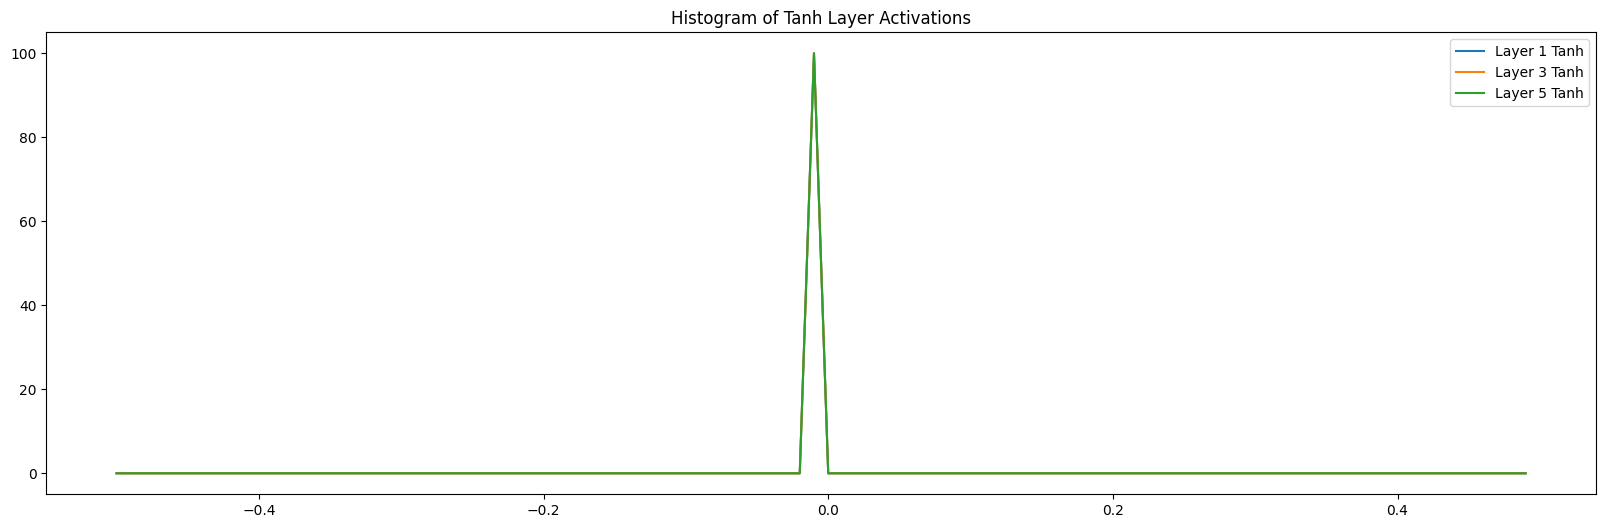

In [25]:
# Collect activations from the Tanh layers
plt.figure(figsize=(20, 6))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"Layer {i}: {layer.__class__.__name__}, Mean: {t.mean():.2f}, Std: {t.std():.2f}, Saturations: {(((t.abs() > 0.97).sum() / t.numel()).item())*100.00:.2f}")        
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        legends.append(f"Layer {i} {layer.__class__.__name__}")

plt.title('Histogram of Tanh Layer Activations')
plt.legend(legends);
plt.show()

### Gradients

Layer 1: Tanh, Mean: 0.0, Std: 0.0
Layer 3: Tanh, Mean: 0.0, Std: 0.0
Layer 5: Tanh, Mean: 0.0, Std: 0.0


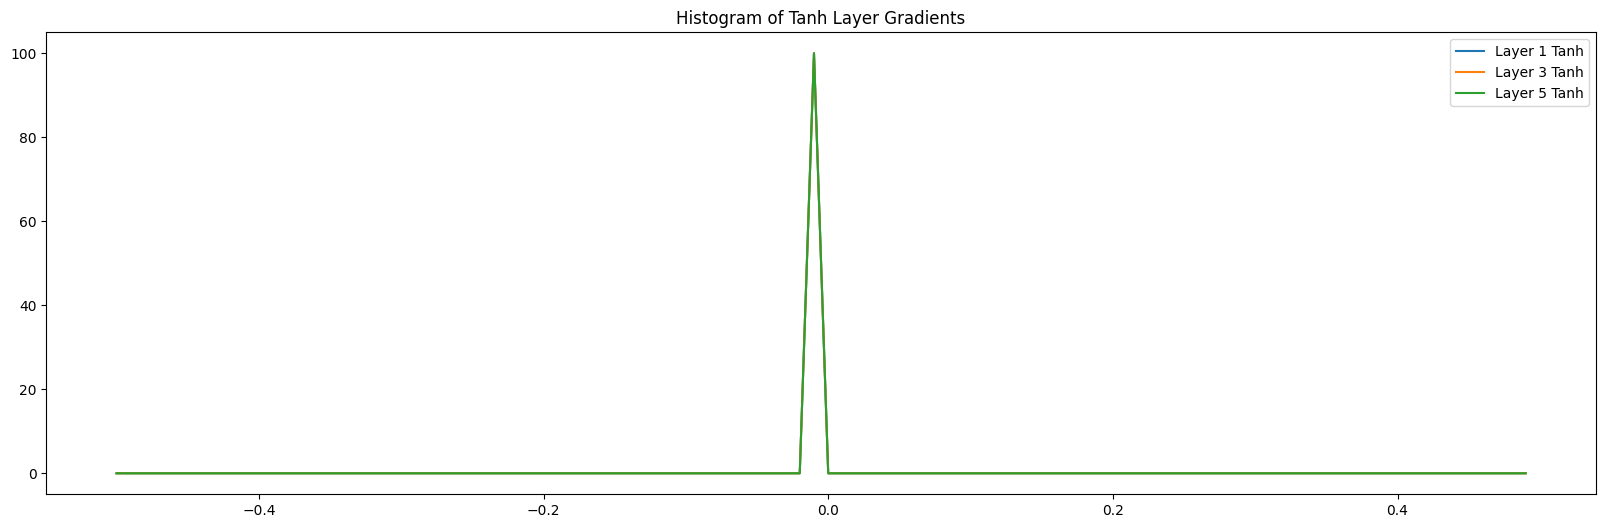

In [30]:
# Collect activations from the Tanh layers
plt.figure(figsize=(20, 6))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        # print(t)
        print(f"Layer {i}: {layer.__class__.__name__}, Mean: {t.mean()}, Std: {t.std()}")        
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        legends.append(f"Layer {i} {layer.__class__.__name__}")

plt.title('Histogram of Tanh Layer Gradients')
plt.legend(legends);
plt.show()

### Grads of each param

Param 0 torch.Size([27, 10]): Mean: 0.0000, Std: 0.00e+00
Param 1 torch.Size([30, 400]): Mean: 0.0000, Std: 0.00e+00
Param 3 torch.Size([400, 400]): Mean: 0.0000, Std: 0.00e+00
Param 5 torch.Size([400, 400]): Mean: 0.0000, Std: 0.00e+00
Param 7 torch.Size([400, 27]): Mean: 0.0000, Std: 0.00e+00


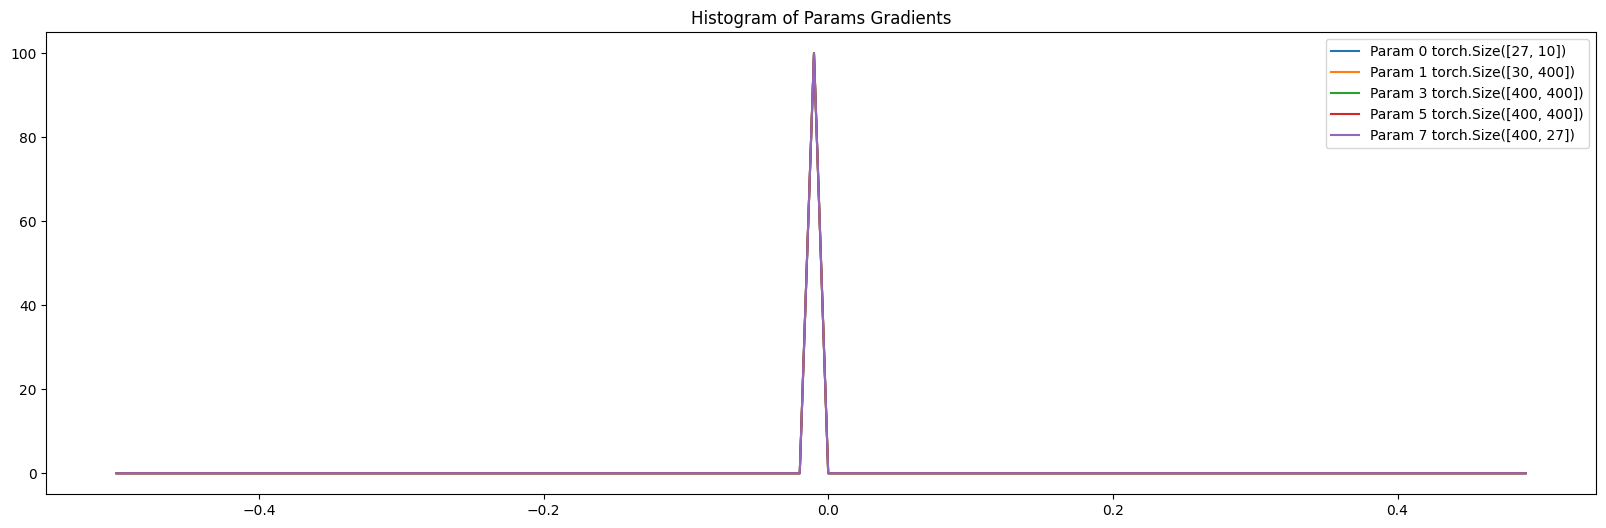

In [31]:
# Collect activations from the Tanh layers
plt.figure(figsize=(20, 6))
legends = []

for i, param in enumerate(params):
    if param.ndim == 2:
        t = param.grad
        print(f"Param {i} {param.shape}: Mean: {t.mean():.4f}, Std: {t.std():.2e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        legends.append(f"Param {i} {param.shape}")

plt.title('Histogram of Params Gradients')
plt.legend(legends);
plt.show()

## Now lets let the network train and see how it proceeds

In [34]:
emb_dim = 10
hidden_dim = 400
window_size = 3
vocab_size = len(stoi)

params, layers = create_model(emb_dim, hidden_dim, window_size, vocab_size)

No of parameters = 344297


In [35]:
# Define the learning rate schedule
lr_schedule = lambda i: 0.01 if i<100000 else 0.001

# Train the network for 1 iteration
stepi, lossi, ud = train(X_train, y_train, params, layers, num_iters=200000, batch_size=128, lr_schedule=lr_schedule)

Step 0 --> 3.295837163925171
Step 10000 --> 2.815326452255249
Step 20000 --> 2.775858163833618
Step 30000 --> 2.70202374458313
Step 40000 --> 2.7630021572113037
Step 50000 --> 2.8888232707977295
Step 60000 --> 2.8279106616973877
Step 70000 --> 2.7671101093292236
Step 80000 --> 2.947364568710327
Step 90000 --> 2.7886016368865967
Step 100000 --> 2.9202797412872314
Step 110000 --> 2.7956652641296387
Step 120000 --> 2.8982808589935303
Step 130000 --> 2.8083138465881348
Step 140000 --> 2.9427688121795654
Step 150000 --> 2.7369093894958496
Step 160000 --> 2.910165548324585
Step 170000 --> 2.964082717895508
Step 180000 --> 2.634094715118408
Step 190000 --> 2.811516046524048


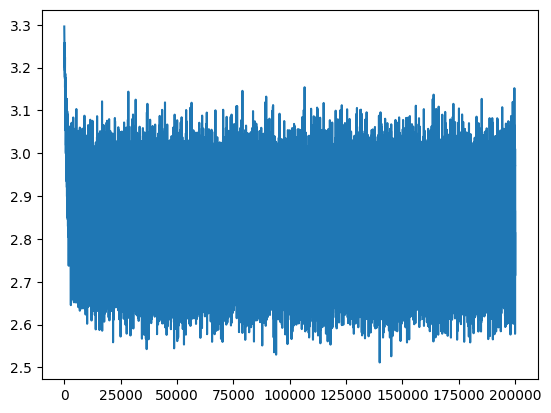

In [36]:
plt.plot(stepi, lossi)

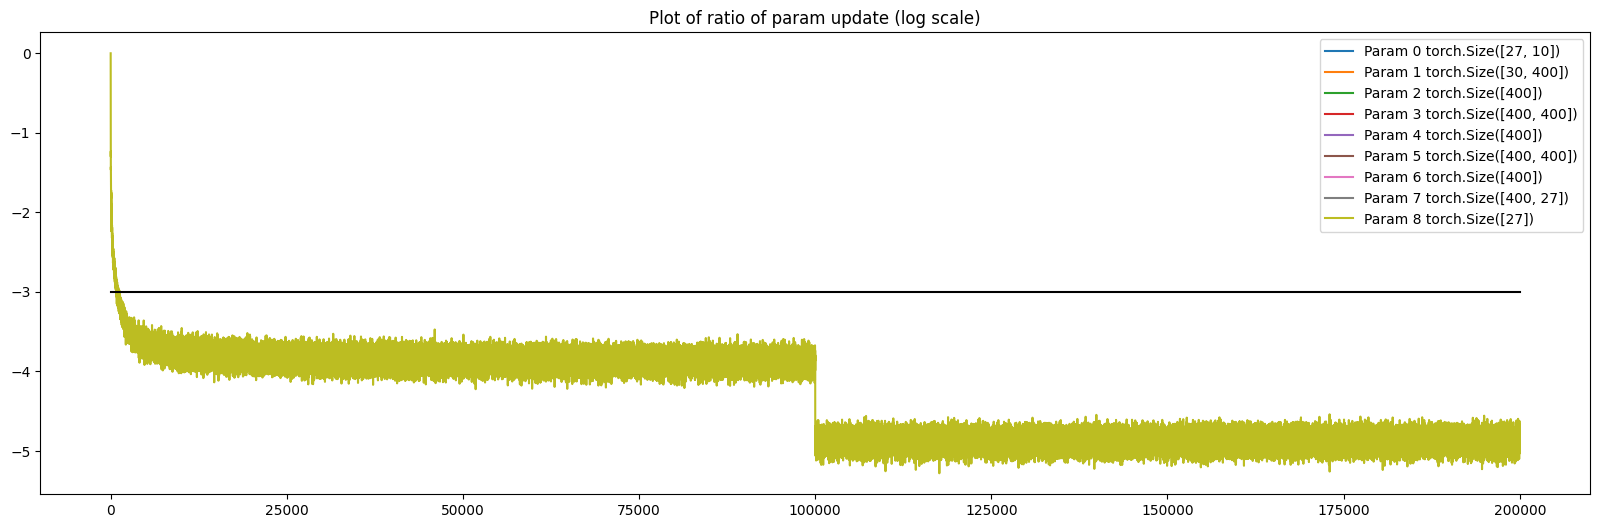

In [42]:
# Plot the update of each param

plt.figure(figsize=(20, 6))
legends = []

for i, param in enumerate(params):
    plt.plot(stepi, ud[:, i])
    legends.append(f"Param {i} {param.shape}")

plt.plot([0, len(ud)], [-3, -3], 'k')
plt.title('Plot of ratio of param update (log scale)')
plt.legend(legends);
plt.show()